In [148]:
!ls ../input

ga-customer-revenue-prediction	make-data-ready


# COMP4651 Project — Kaggle competition https://www.kaggle.com/c/ga-customer-revenue-prediction/overview
### - Data collected from https://www.kaggle.com/qnkhuat/make-data-ready/code
### - Those data are already cleaned!!!
### - Please read the code within the website to understand what is cleaned and processed!!!

In [3]:
import numpy as np
import pandas as pd
import sys
import os
import os.path as osp
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

sns.set()

%matplotlib inline

In [4]:
train_data = None
test_data = None

for i in range(9):
    if i == 0:
        train_data = pd.read_pickle(osp.join("", "", "", "train_"+str(i)+".pkl"))
        continue
    else:
        temp = pd.read_pickle(osp.join("", "", "", "train_"+str(i)+".pkl"))
        train_data = pd.concat([train_data, temp], ignore_index=True)

for j in range(3):
    if j == 0:
        test_data = pd.read_pickle(osp.join("", "", "", "test_"+str(j)+".pkl"))
        continue
    else:
        temp = pd.read_pickle(osp.join("", "", "", "test_"+str(j)+".pkl"))
        test_data = pd.concat([test_data, temp], ignore_index=True)
    


In [5]:
print(type(train_data))
print(type(test_data))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [6]:
print(train_data.columns)

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem', 'geoNetwork_city',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim',
       'totals_timeOnSite', 'totals_totalTransactionRevenue',
       'totals_transactionRevenue', 'totals_transactions', 'totals_visits',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       '

653534     2.312950e+10
764560     1.785550e+10
668147     1.602375e+10
1020100    1.322940e+10
810066     1.229300e+10
1449340    1.058914e+10
1316657    9.925110e+09
1693239    8.677830e+09
1349475    8.248800e+09
270728     7.427430e+09
Name: totals_transactionRevenue, dtype: float64 

1135634    0.0
1135635    0.0
1135636    0.0
1135637    0.0
1135638    0.0
1135639    0.0
1135640    0.0
1135641    0.0
1135642    0.0
0          0.0
Name: totals_transactionRevenue, dtype: float64 

count    1.708337e+06
mean     1.355906e+06
std      4.522809e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.312950e+10
Name: totals_transactionRevenue, dtype: float64 



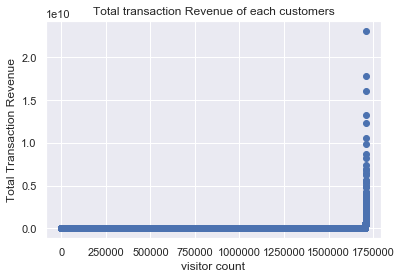

In [7]:
sorted_revenue = train_data['totals_transactionRevenue'].sort_values(ascending=False)
top_10_revenue = sorted_revenue.head(10)
least_10_revenue = sorted_revenue.tail(10)

print(top_10_revenue, '\n')
print(least_10_revenue, '\n')
print(sorted_revenue.describe(), '\n')

# train_data.plot.scatter(x='visitId', y='totals_transactionRevenue')
plt.scatter(x=range(len(sorted_revenue)), y=sorted_revenue.sort_values(ascending=True))

plt.title("Total transaction Revenue of each customers")
plt.xlabel("visitor count")
plt.ylabel("Total Transaction Revenue")

plt.show()

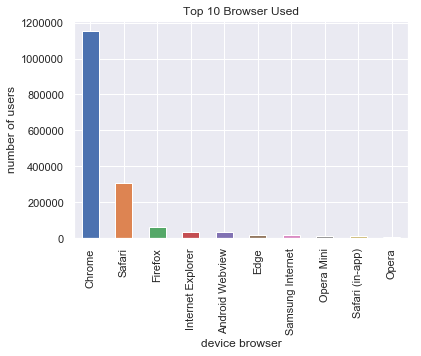

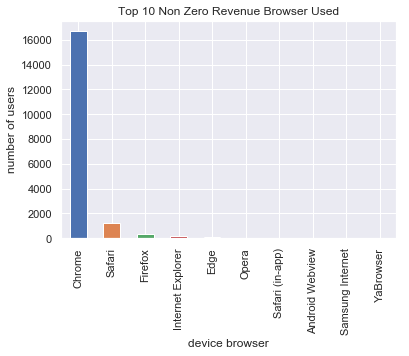

In [8]:
Top10_browser_used = train_data.groupby('device_browser')['visitId'].nunique().sort_values(ascending=False).head(10)
Top10_browser_used.plot.bar()

plt.title("Top 10 Browser Used")
plt.xlabel("device browser")
plt.ylabel("number of users")

plt.show()

Top10_nonzero_revenue_browser_used = train_data[train_data.totals_transactionRevenue>0].groupby('device_browser')['visitId'].nunique().sort_values(ascending=False).head(10)

Top10_nonzero_revenue_browser_used.plot.bar()

plt.title("Top 10 Non Zero Revenue Browser Used")
plt.xlabel("device browser")
plt.ylabel("number of users")

plt.show()

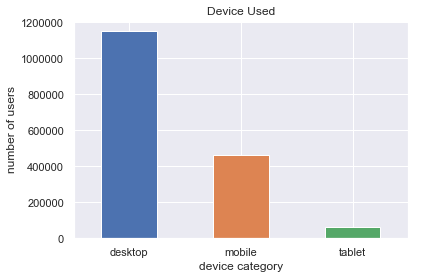

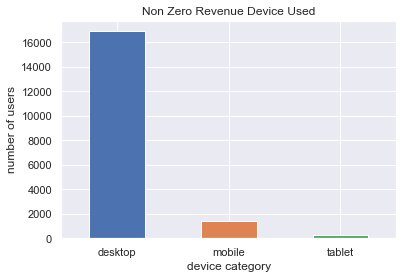

In [9]:
Device_used = train_data.groupby('device_deviceCategory')['visitId'].nunique().sort_values(ascending=False).head(10)

Device_used.plot.bar()

plt.title("Device Used")
plt.xlabel("device category")
plt.ylabel("number of users")

plt.xticks(rotation=0)

plt.show()

Nonzero_revenue_device_used = train_data[train_data.totals_transactionRevenue>0].groupby('device_deviceCategory')['visitId'].nunique().sort_values(ascending=False).head(10)

Nonzero_revenue_device_used.plot.bar()

plt.title("Non Zero Revenue Device Used")
plt.xlabel("device category")
plt.ylabel("number of users")

plt.xticks(rotation=0)

plt.show()

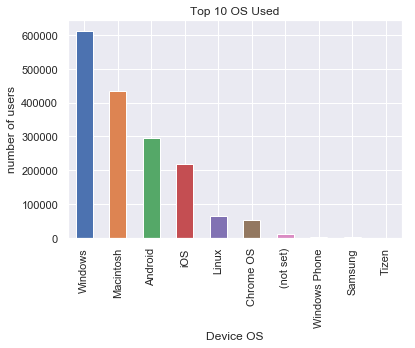

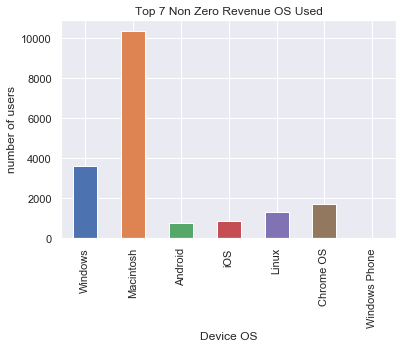

In [10]:
Top10_OS_used = train_data.groupby('device_operatingSystem')['visitId'].nunique().sort_values(ascending=False).head(10)

Top10_OS_used.plot.bar()

plt.title("Top 10 OS Used")
plt.xlabel("Device OS")
plt.ylabel("number of users")

plt.show()

Top10_nonzero_revenue_OS_used = train_data[train_data.totals_transactionRevenue>0].groupby('device_operatingSystem')['visitId'].nunique().sort_values(ascending=False).head(10)


new_index = ['Windows', 'Macintosh',  'Android', 'iOS', 'Linux', 'Chrome OS', 'Windows Phone']

Top10_nonzero_revenue_OS_used = Top10_nonzero_revenue_OS_used.reindex(new_index)

Top10_nonzero_revenue_OS_used.plot.bar()

plt.title("Top 7 Non Zero Revenue OS Used")
plt.xlabel("Device OS")
plt.ylabel("number of users")

plt.show()

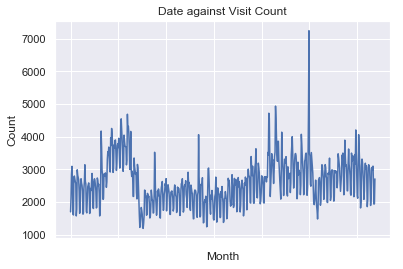

In [11]:
import matplotlib.pyplot as plt

Date_against_visitcount = train_data.groupby(['Date_Year', 'Date_Month', 'Date_Day'])['visitId'].nunique()

Date_against_visitcount.plot()

plt.title("Date against Visit Count")
plt.xlabel("Month")
plt.ylabel("Count")


plt.show()

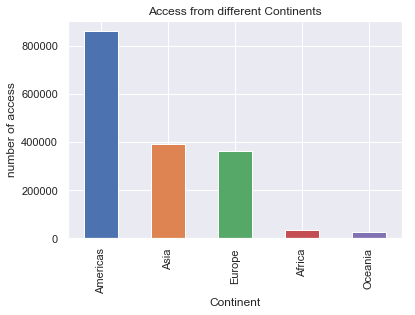

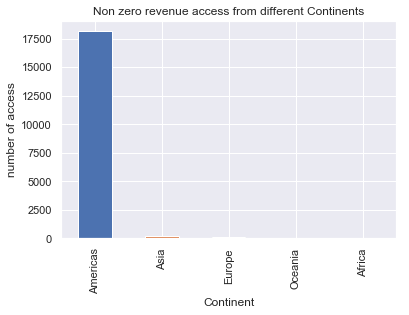

In [12]:
continent = train_data.groupby('geoNetwork_continent')['visitId'].nunique().sort_values(ascending=False).head(5)

continent.plot.bar()

plt.title("Access from different Continents")
plt.xlabel("Continent")
plt.ylabel("number of access")

plt.show()

continent_nonzero_revenue = train_data[train_data.totals_transactionRevenue>0].groupby('geoNetwork_continent')['visitId'].nunique().sort_values(ascending=False).head(5)

continent_nonzero_revenue.plot.bar()

plt.title("Non zero revenue access from different Continents")
plt.xlabel("Continent")
plt.ylabel("number of access")

plt.show()

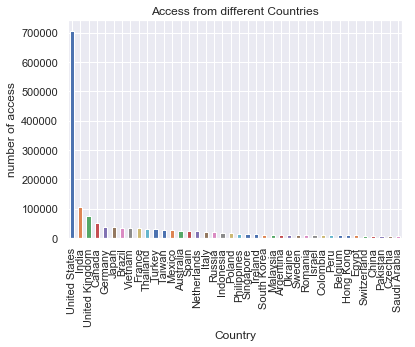

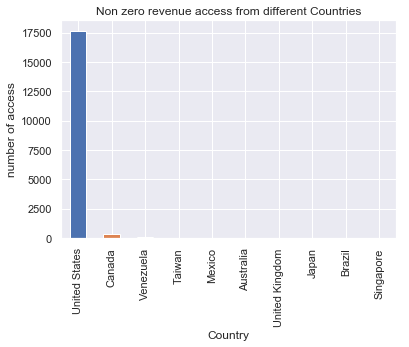

In [13]:
country = train_data.groupby('geoNetwork_country')['visitId'].nunique().sort_values(ascending=False).head(40)

country.plot.bar()

plt.title("Access from different Countries")
plt.xlabel("Country")
plt.ylabel("number of access")

plt.show()

country_nonzero_revenue = train_data[train_data.totals_transactionRevenue>0].groupby('geoNetwork_country')['visitId'].nunique().sort_values(ascending=False).head(10)

country_nonzero_revenue.plot.bar()

plt.title("Non zero revenue access from different Countries")
plt.xlabel("Country")
plt.ylabel("number of access")

plt.show()

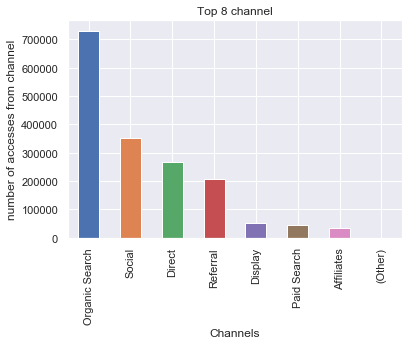

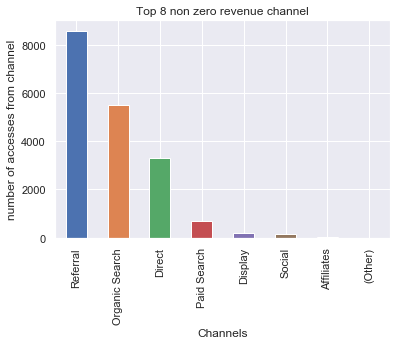

In [14]:
Top8_channel = train_data.groupby('channelGrouping')['visitId'].nunique().sort_values(ascending=False).head(10)
Top8_channel.plot.bar()

plt.title("Top 8 channel")
plt.xlabel("Channels")
plt.ylabel("number of accesses from channel")

plt.show()

Top8_channel_nonzero_revenue = train_data[train_data.totals_transactionRevenue>0].groupby('channelGrouping')['visitId'].nunique().sort_values(ascending=False).head(10)
Top8_channel_nonzero_revenue.plot.bar()

plt.title("Top 8 non zero revenue channel")
plt.xlabel("Channels")
plt.ylabel("number of accesses from channel")

plt.show()

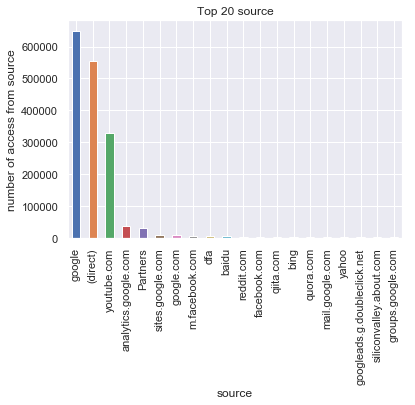

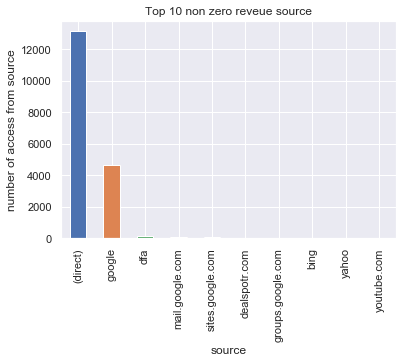

In [15]:
Top20_source = train_data.groupby('trafficSource_source')['visitId'].nunique().sort_values(ascending=False).head(20)
Top20_source.plot.bar()

plt.title("Top 20 source")
plt.xlabel("source")
plt.ylabel("number of access from source")


plt.show()

Top10_source_nonzero_revenue = train_data[train_data.totals_transactionRevenue>0].groupby('trafficSource_source')['visitId'].nunique().sort_values(ascending=False).head(10)
Top10_source_nonzero_revenue.plot.bar()

plt.title("Top 10 non zero reveue source")
plt.xlabel("source")
plt.ylabel("number of access from source")


plt.show()

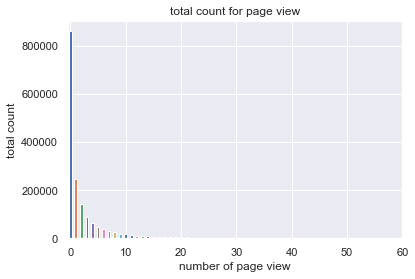

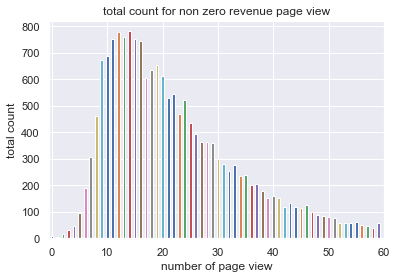

In [16]:
total_pageview = train_data.groupby('totals_pageviews')['visitId'].nunique().sort_values(ascending=False).head(60)
total_pageview.plot.bar()

plt.title("total count for page view")
plt.xlabel("number of page view")
plt.ylabel("total count")

plt.xticks(range(0,61, 10), range(0,61, 10), rotation=0) # ticks = ..., labels = ...


plt.show()

total_pageview_nonzero_revenue = train_data[train_data.totals_transactionRevenue>0].groupby('totals_pageviews')['visitId'].nunique().head(60)
total_pageview_nonzero_revenue.plot.bar()

plt.title("total count for non zero revenue page view")
plt.xlabel("number of page view")
plt.ylabel("total count")

plt.xticks(range(0,61, 10), range(0,61, 10), rotation=0) # ticks = ..., labels = ...

plt.show()

In [17]:
test_id = test_data["fullVisitorId"].values
X_train= train_data.drop(columns=['totals_totalTransactionRevenue', 'totals_transactionRevenue']).apply(lambda x: pd.factorize(x)[0])
y_train = train_data['totals_transactionRevenue'].apply(lambda x: np.log1p(x))
X_test = test_data.drop(columns=['totals_totalTransactionRevenue', 'totals_transactionRevenue']).apply(lambda x: pd.factorize(x)[0])
y_test = test_data['totals_transactionRevenue'].apply(lambda x: np.log1p(x))


print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1708337, 51) (1708337,)
(401589, 51) (401589,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from time import time
from lightgbm import LGBMClassifier;

# Import Data


# Define preprocessing and classification pipeline

classifier = LGBMClassifier()


random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=n_iter_search, cv=n_folds, 
                                   n_jobs=-1, verbose=2)

start = time()

random_search.fit(X_train, y_train)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
      
print("\nBest Score = " + str(random_search.best_score_))

print("\nBest Parameters = " + str(random_search.best_params_))

In [18]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
evals_result = {}
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 128,
    'max_depth': 6,
    'max_bin': 255,
    'learning_rate': 0.02,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=5000,
                valid_sets=[lgb_train, lgb_eval],
                early_stopping_rounds=100,
                verbose_eval=50,
                evals_result=evals_result)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Starting training...
Training until validation scores don't improve for 100 rounds.
[50]	training's rmse: 0.930271	valid_1's rmse: 1.19435
[100]	training's rmse: 0.590431	valid_1's rmse: 1.06823
[150]	training's rmse: 0.361235	valid_1's rmse: 1.0198
[200]	training's rmse: 0.248656	valid_1's rmse: 1.04119
[250]	training's rmse: 0.182984	valid_1's rmse: 1.07904
Early stopping, best iteration is:
[153]	training's rmse: 0.349415	valid_1's rmse: 1.01861
Saving model...
Starting predicting...
The rmse of prediction is: 1.018612892578557


In [19]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
y_pred[y_pred<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(y_pred)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df.to_csv("submission.csv", index=False)

In [20]:
sub_df.head(10)

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.000000
1,0000039738481224681,0.501015
2,0000073585230191399,0.712151
3,0000087588448856385,0.011733
4,0000149787903119437,0.082262
5,0000196310838896290,0.141642
6,00001995526696366,0.001195
7,0000255704530917106,0.564943
8,0000268499301061358,0.111344
9,0000276747989270229,0.225706


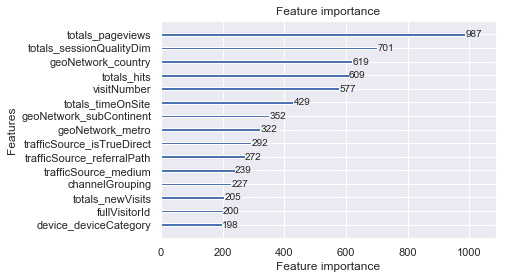

In [21]:
lgb.plot_importance(gbm, max_num_features=15)

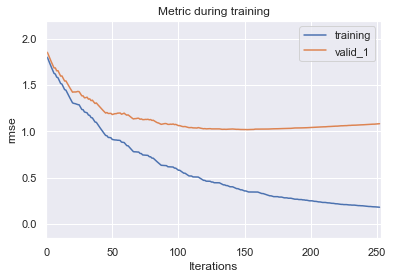

In [22]:
lgb.plot_metric(evals_result, metric='rmse')

In [ ]:
import numpy as np

from time import time
from scipy.stats import randint as sp_randint

# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# build a classifier
clf = RandomForestClassifier(n_estimators=20)
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X_train.values, y_train.values.astype('int'))
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

In [36]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=50, max_depth=15,random_state=0)
clf.fit(X_train.values, y_train.values.astype('int'))
y_pred = clf.predict(X_test)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 1.7406097852629445


In [ ]:
import time

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

clf = xgb.XGBClassifier()

param_grid = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 6,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}

xgb_train_data = xgb.DMatrix(X_train[:1366669], y_train[:1366669])
xgb_val_data = xgb.DMatrix(X_train[1366669:], y_train[1366669:])
xgb_submit_data = xgb.DMatrix(X_test)

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=20,
                            n_jobs=1, verbose=2, cv=2,
                            refit=False,num_boost_round=200, 
                              evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                              early_stopping_rounds=10, 
                              verbose_eval=50)
print("Randomized search..")
search_time_start = time.time()
rs_clf.fit(x_train, y_train)
print("Randomized search time:", time.time() - search_time_start)

best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

In [37]:
import xgboost as xgb

params = {'objective': 'reg:linear',
              'eval_metric': 'rmse',
              'eta': 0.001,
              'max_depth': 6,
              'subsample': 0.6,
              'colsample_bytree': 0.6,
              'alpha':0.001,
              'random_state': 42,
              'silent': True}


#gbm = xgb.XGBClassifier(max_depth=6, n_estimators=300, learning_rate=0.05)\
  #  .fit(X_train.values, y_train.values.astype('int'))
#y_pred = gbm.predict(test_X)

xgb_train_data = xgb.DMatrix(X_train[:1366669], y_train[:1366669])
xgb_val_data = xgb.DMatrix(X_train[1366669:], y_train[1366669:])
xgb_submit_data = xgb.DMatrix(X_test)

model = xgb.train(params, xgb_train_data, 
                      num_boost_round=200, 
                      evals= [(xgb_train_data, 'train'), (xgb_val_data, 'valid')],
                      early_stopping_rounds=10, 
                      verbose_eval=50
                     )

y_pred = model.predict(xgb_submit_data, ntree_limit=model.best_ntree_limit)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

[0]	train-rmse:1.87017	valid-rmse:1.85752
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[50]	train-rmse:1.80623	valid-rmse:1.79404
[100]	train-rmse:1.73962	valid-rmse:1.72789
[150]	train-rmse:1.67864	valid-rmse:1.66739
[199]	train-rmse:1.61833	valid-rmse:1.60752
The rmse of prediction is: 1.7020937766417257


Best : {'num_leaves': 6}
